# LUDB validation

In [22]:
# Standard library imports
from os import listdir

# Third-party imports
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

ROWS, COLS = (3, 4)
DATA_LEN = 5000
STANDARD = [
    "I",
    "II",
    "III",
    "aVR",
    "aVL",
    "aVF",
    "V1",
    "V2",
    "V3",
    "V4",
    "V5",
    "V6",
]
RYTHM = ["II"]


In [23]:
ORIGINAL_DIR = "./original/signal/"
original_files = [file for file in listdir(ORIGINAL_DIR) if file.endswith(".csv")]
original_files = sorted(original_files, key=lambda x: (len(x), x[0]))

In [24]:
DIGITIZED_DIR = "./digitized/signal/"
digitized_files = [
    file for file in listdir(DIGITIZED_DIR) if file.endswith(".csv")
]
digitized_files = sorted(digitized_files, key=lambda x: (len(x), x[0]))

In [25]:
assert(original_files == digitized_files)

## Metrics

In [26]:
def pcc(y_true, y_pred):
    return y_true.corr(y_pred)

def rmse(y_true, y_pred):
    return sqrt(sum((y_true - y_pred) ** 2) / len(y_true))


In [27]:
PACEMAKER = [8, 34, 45, 74, 90, 93, 95, 104, 111]
OUTLIER = []
DISCARDED = set(PACEMAKER+OUTLIER)
XR_OBS = 7
COLUMN_NAMES = ["ecg_id"] + [lead for lead in STANDARD]
TO_MICROVOLTS = lambda x: 1000 * x
files = [f for f in original_files if int(f[:3]) not in DISCARDED]
N = len(files)

pcc_df = pd.DataFrame(np.empty((N, len(COLUMN_NAMES))), columns=COLUMN_NAMES)
rmse_df = pd.DataFrame(np.empty((N, len(COLUMN_NAMES))), columns=COLUMN_NAMES)

with tqdm(total=N) as pbar:
    for i, file in enumerate(files):
        ecg_id = int(file[:3])
        original_df = pd.read_csv(ORIGINAL_DIR + file)
        digitized_df = pd.read_csv(DIGITIZED_DIR + file)
        
        pcc_df.iloc[i, 0] = ecg_id
        rmse_df.iloc[i, 0] = ecg_id
        for j, lead in enumerate(STANDARD):
            not_na = digitized_df[lead].notna().values
            y_true = TO_MICROVOLTS(original_df.loc[not_na, lead])[XR_OBS:-XR_OBS or None]
            y_pred = TO_MICROVOLTS(digitized_df.loc[not_na, lead])[XR_OBS:-XR_OBS or None]
            pcc_df.iloc[i, j + 1] = pcc(y_true, y_pred)
            rmse_df.iloc[i, j + 1] = rmse(y_true, y_pred)
        pbar.update(1)


100%|██████████| 191/191 [00:06<00:00, 29.63it/s]


## Summary

In [28]:
summary = pd.DataFrame(
    np.empty((12, 2)),
    index=STANDARD,
    columns=["PCC", "RMSE"],
)
FORMAT = lambda x: str(round(x, 3))
for i, lead in enumerate(STANDARD):
    for j, metric in enumerate([pcc_df, rmse_df]):
        lead_metrics = metric[lead]
        mean = lead_metrics.mean()
        std = lead_metrics.std()
        summary.iloc[i, j] = FORMAT(mean) + " ± " + FORMAT(std)
summary


,PCC,RMSE
I,0.979 ± 0.013,23.736 ± 5.154
II,0.988 ± 0.009,16.595 ± 4.731
III,0.971 ± 0.022,21.06 ± 6.559
aVR,0.987 ± 0.008,18.93 ± 4.087
aVL,0.977 ± 0.024,19.121 ± 6.158
aVF,0.981 ± 0.016,17.152 ± 5.469
V1,0.994 ± 0.003,13.814 ± 2.774
V2,0.993 ± 0.007,12.83 ± 3.139
V3,0.993 ± 0.005,12.649 ± 3.638
V4,0.992 ± 0.004,15.307 ± 3.178


## Visualization

In [29]:
def visualize(file):
    STANDARD = [
        "I",
        "II",
        "III",
        "aVR",
        "aVL",
        "aVF",
        "V1",
        "V2",
        "V3",
        "V4",
        "V5",
        "V6",
    ]
    fig, axs = plt.subplots(6, 2, figsize=(15, 15))
    fig.suptitle(f"{file}", fontsize=25)
    original_df = pd.read_csv(ORIGINAL_DIR + file)
    digitized_df = pd.read_csv(DIGITIZED_DIR + file)
    for i, lead in enumerate(STANDARD):
        not_na = digitized_df[lead].notna().values
        y_true = original_df.loc[not_na,lead]
        y_pred = digitized_df.loc[not_na,lead]
        ax = axs[i % 6, i // 6]
        ax.set(xlabel="Time", ylabel="Voltage")
        ax.plot(
            range(len(y_true)),
            y_true,
            color="blue",
        )
        ax.plot(
            range(len(y_pred)),
            y_pred,
            color="red",
        )
        ax.set_title(lead, fontsize=15)
    fig.legend(labels=["True", "Digitized"], loc="upper right", prop={"size": 15})
    plt.subplots_adjust(
        left=0.1, bottom=0.05, right=0.9, top=0.9, wspace=0.2, hspace=0.7
    )
    
    plt.show()


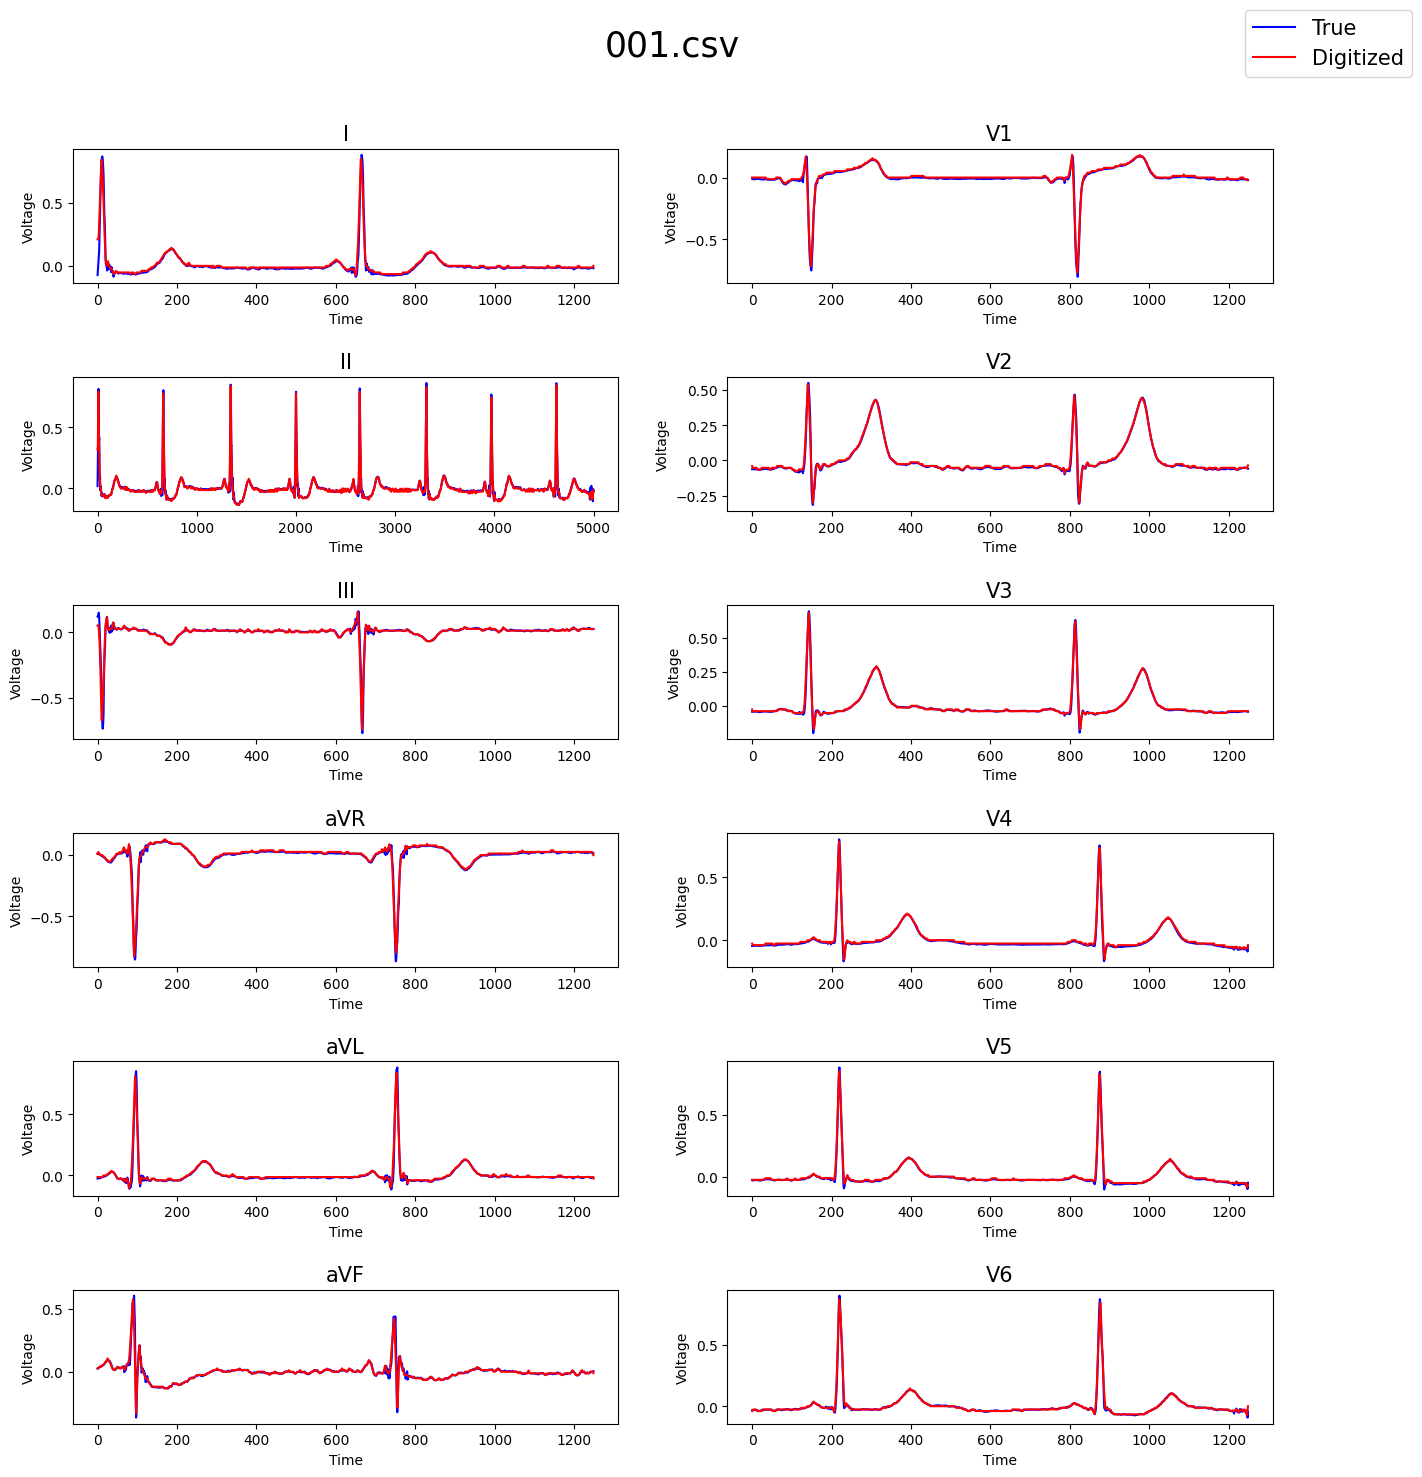

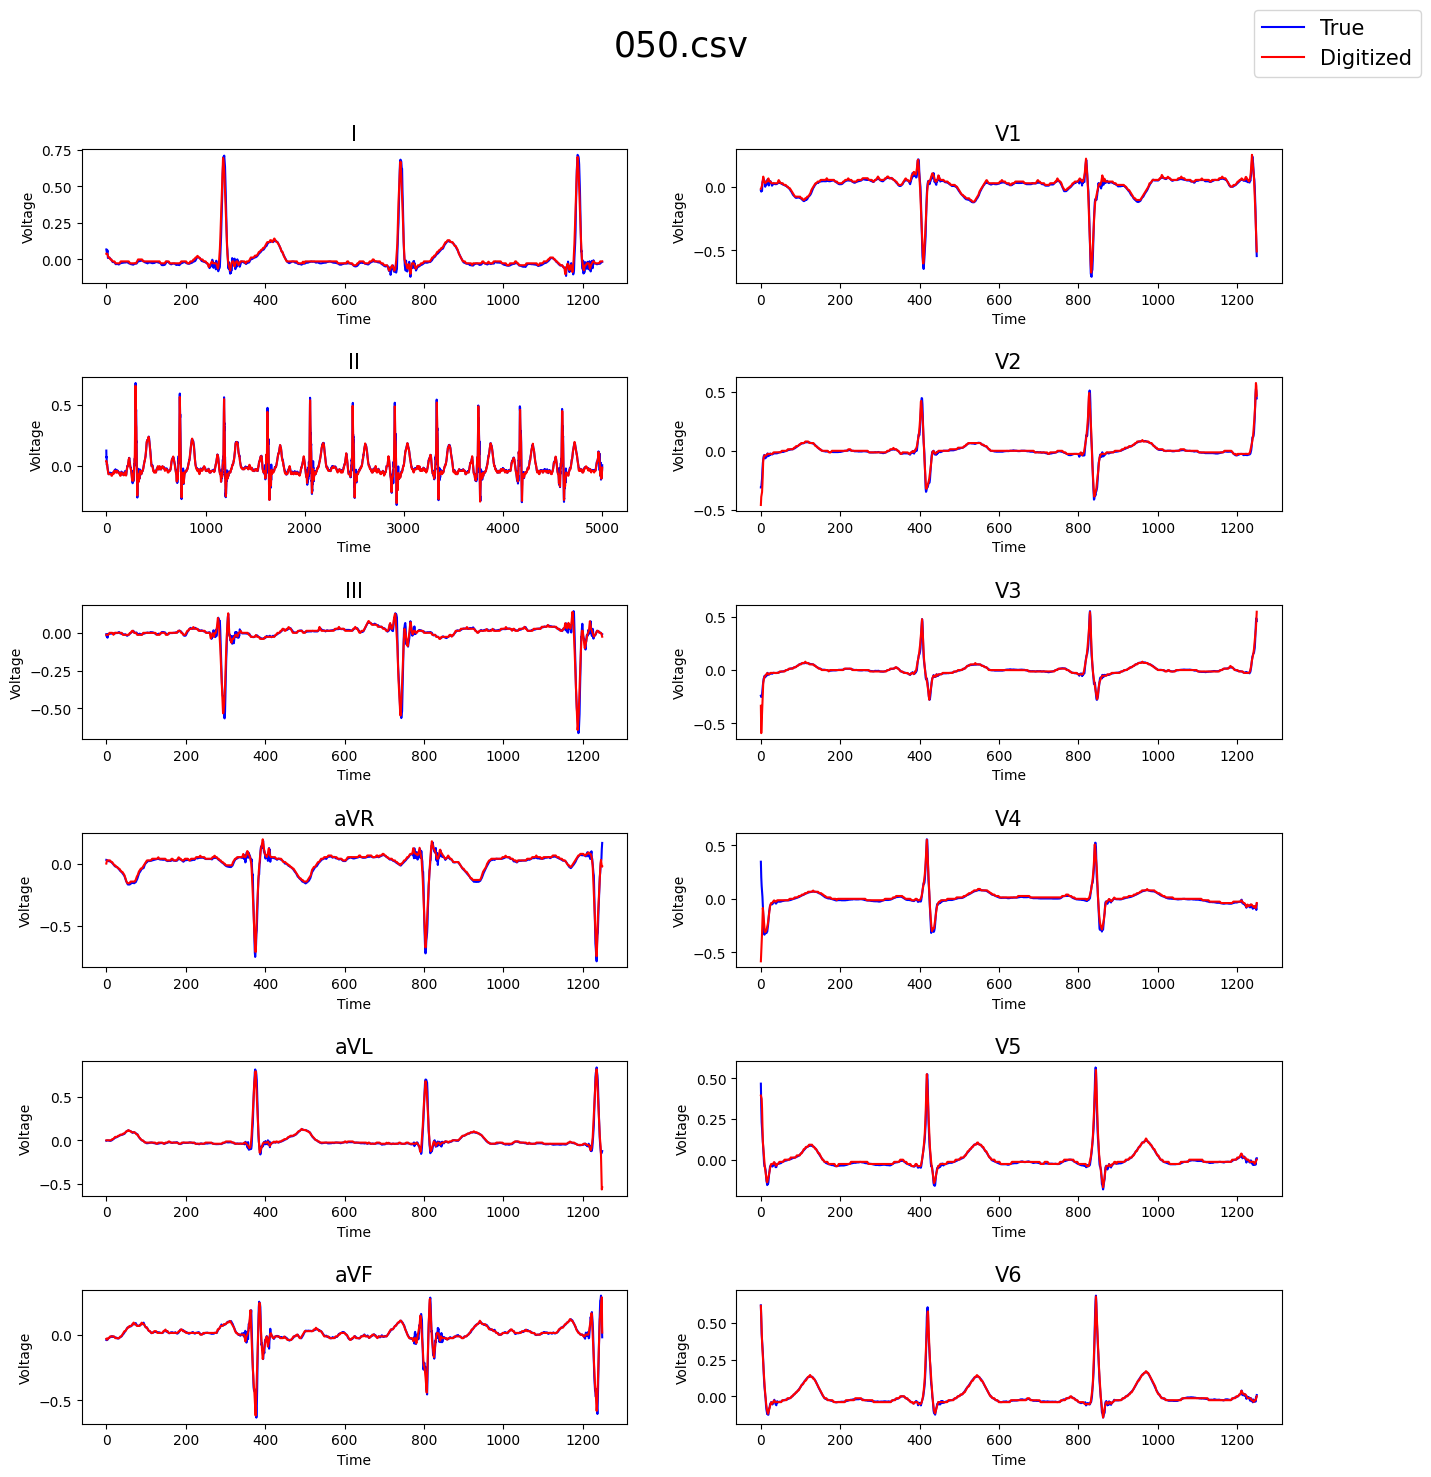

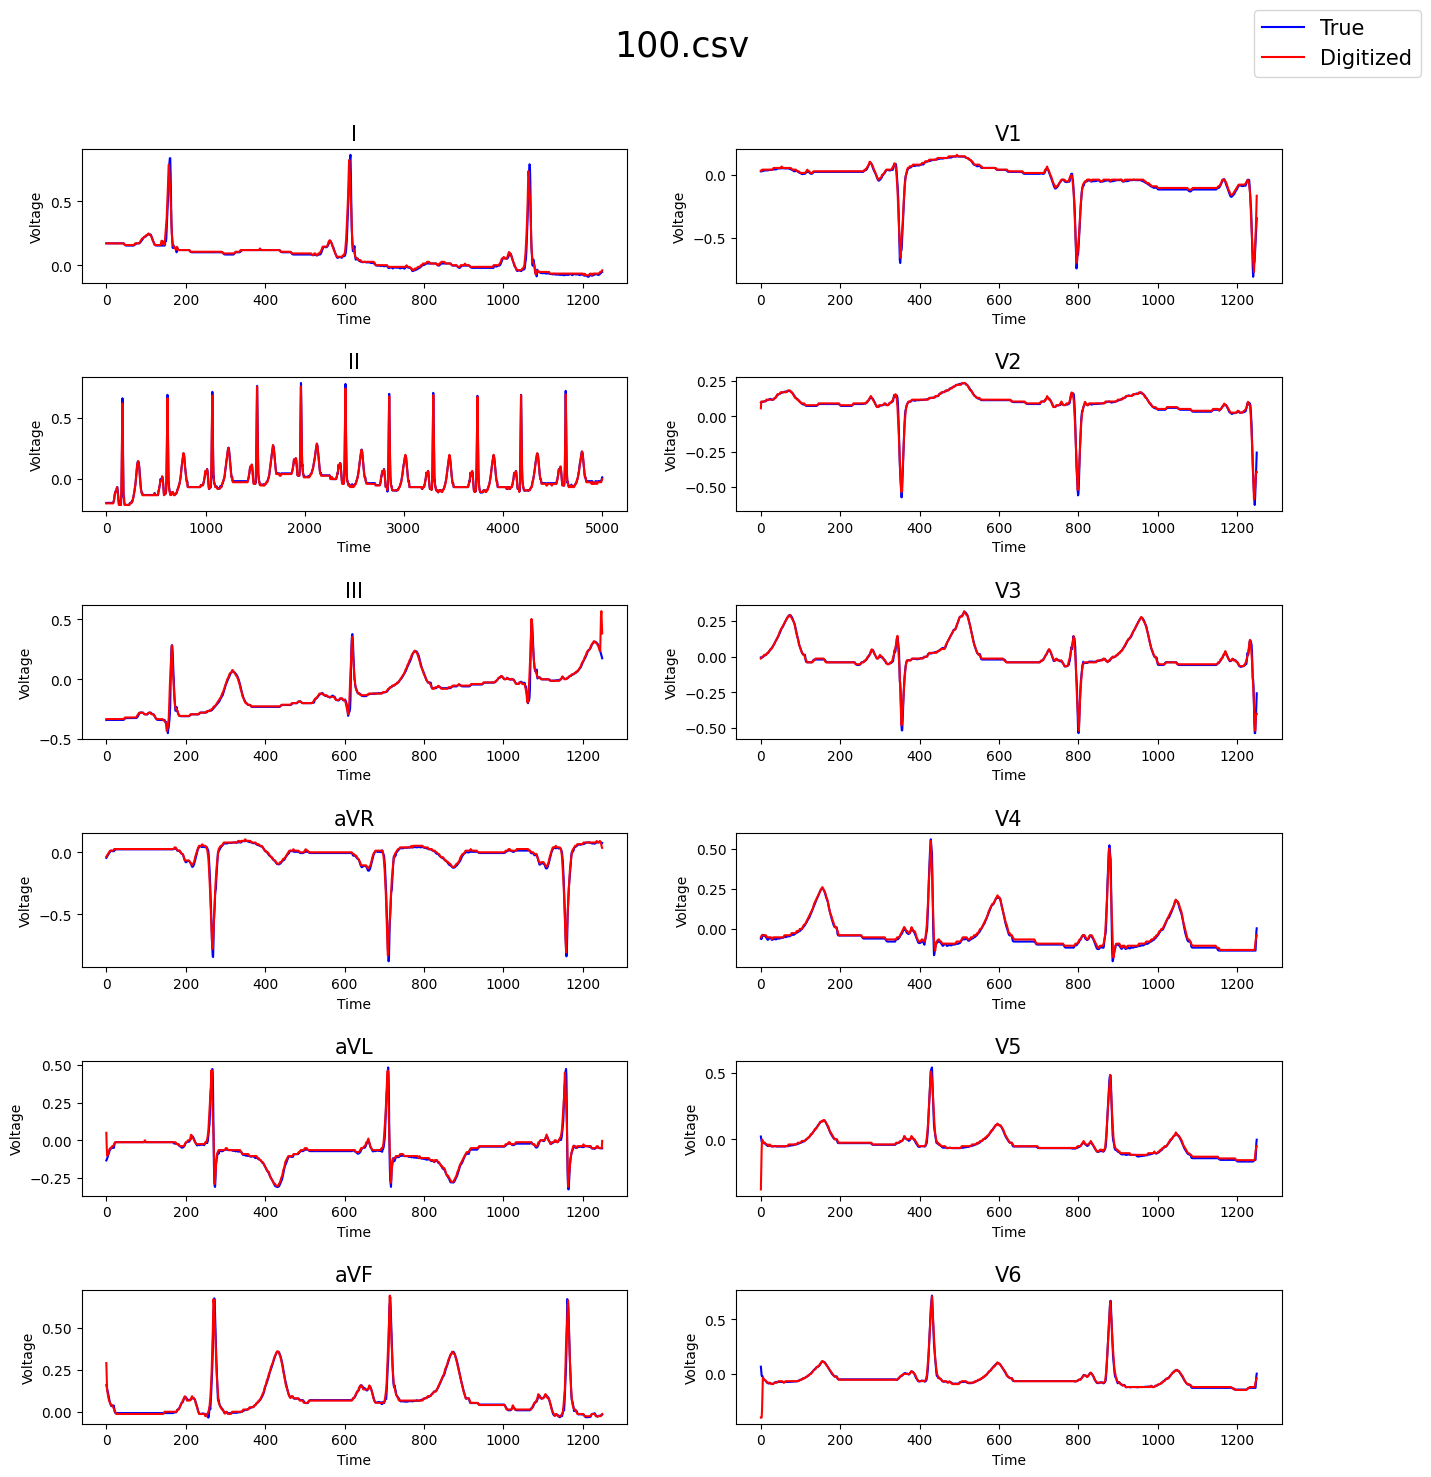

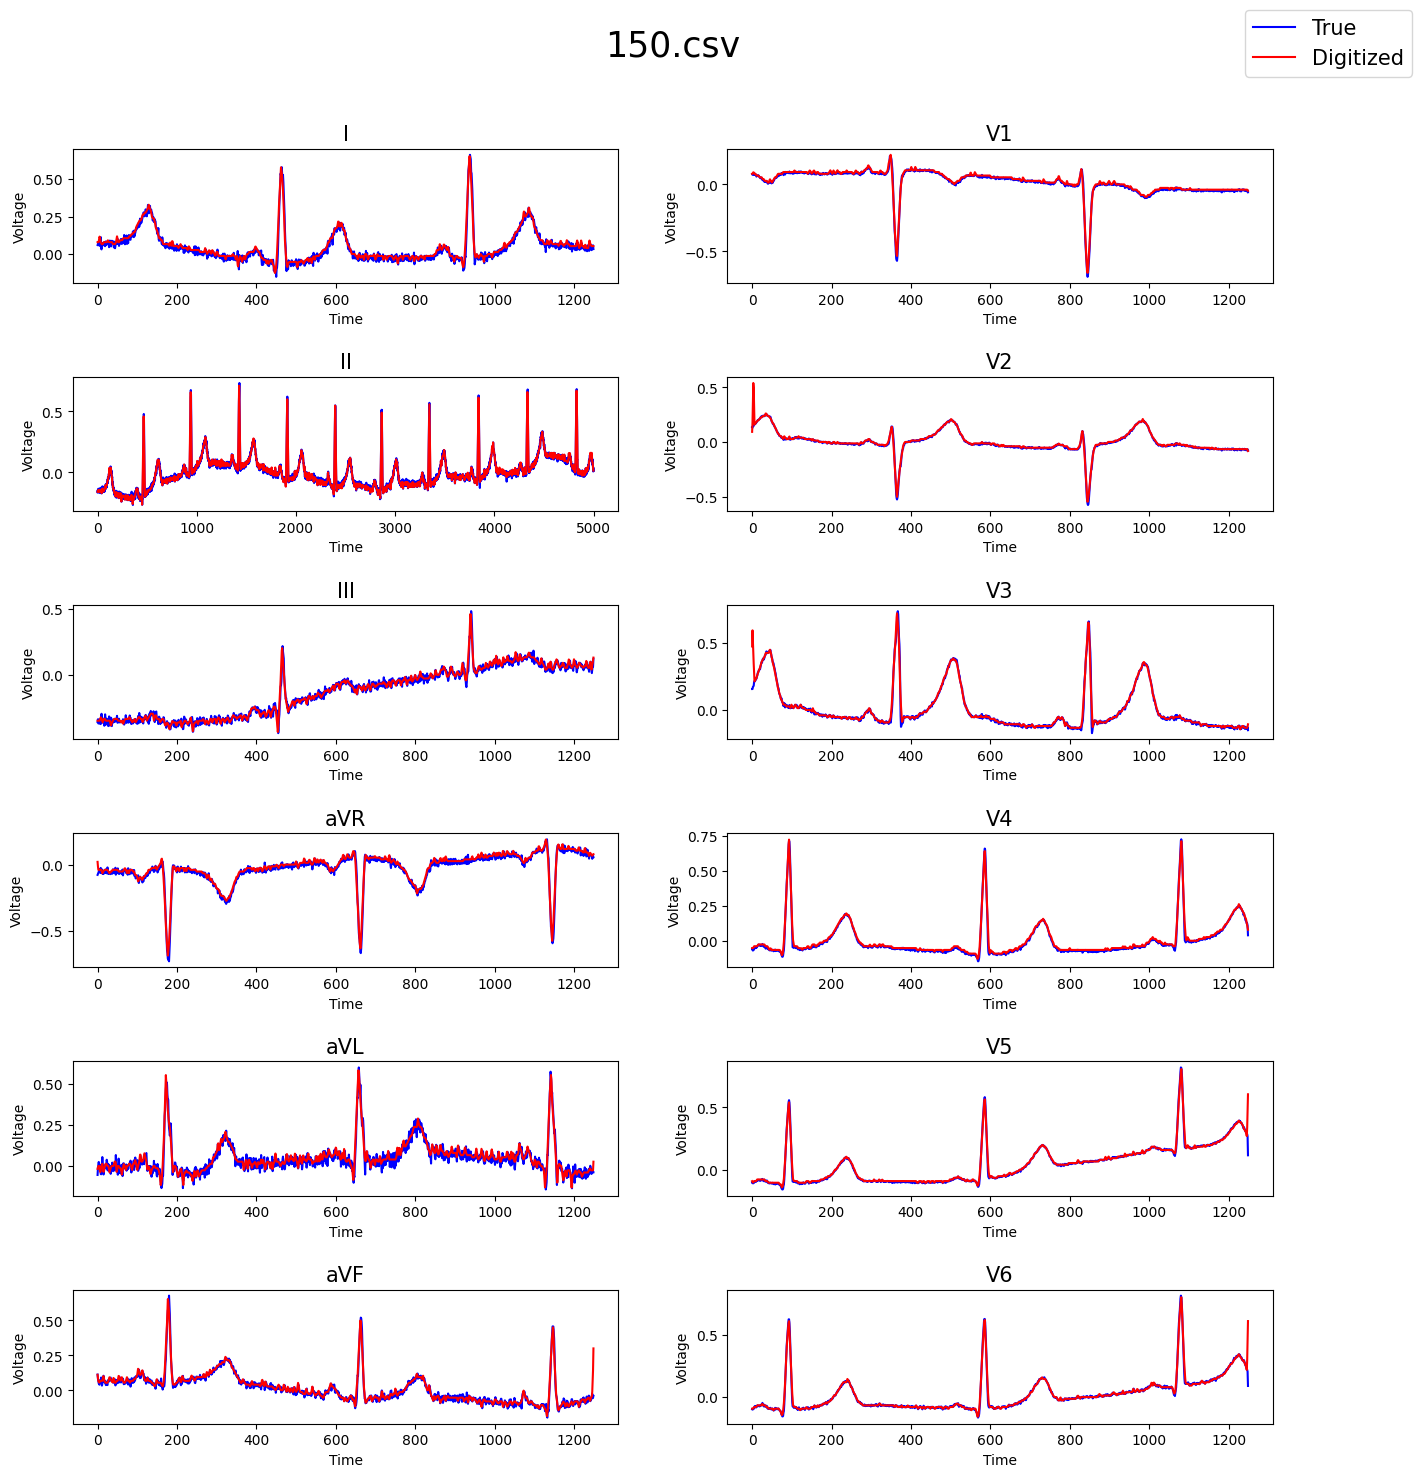

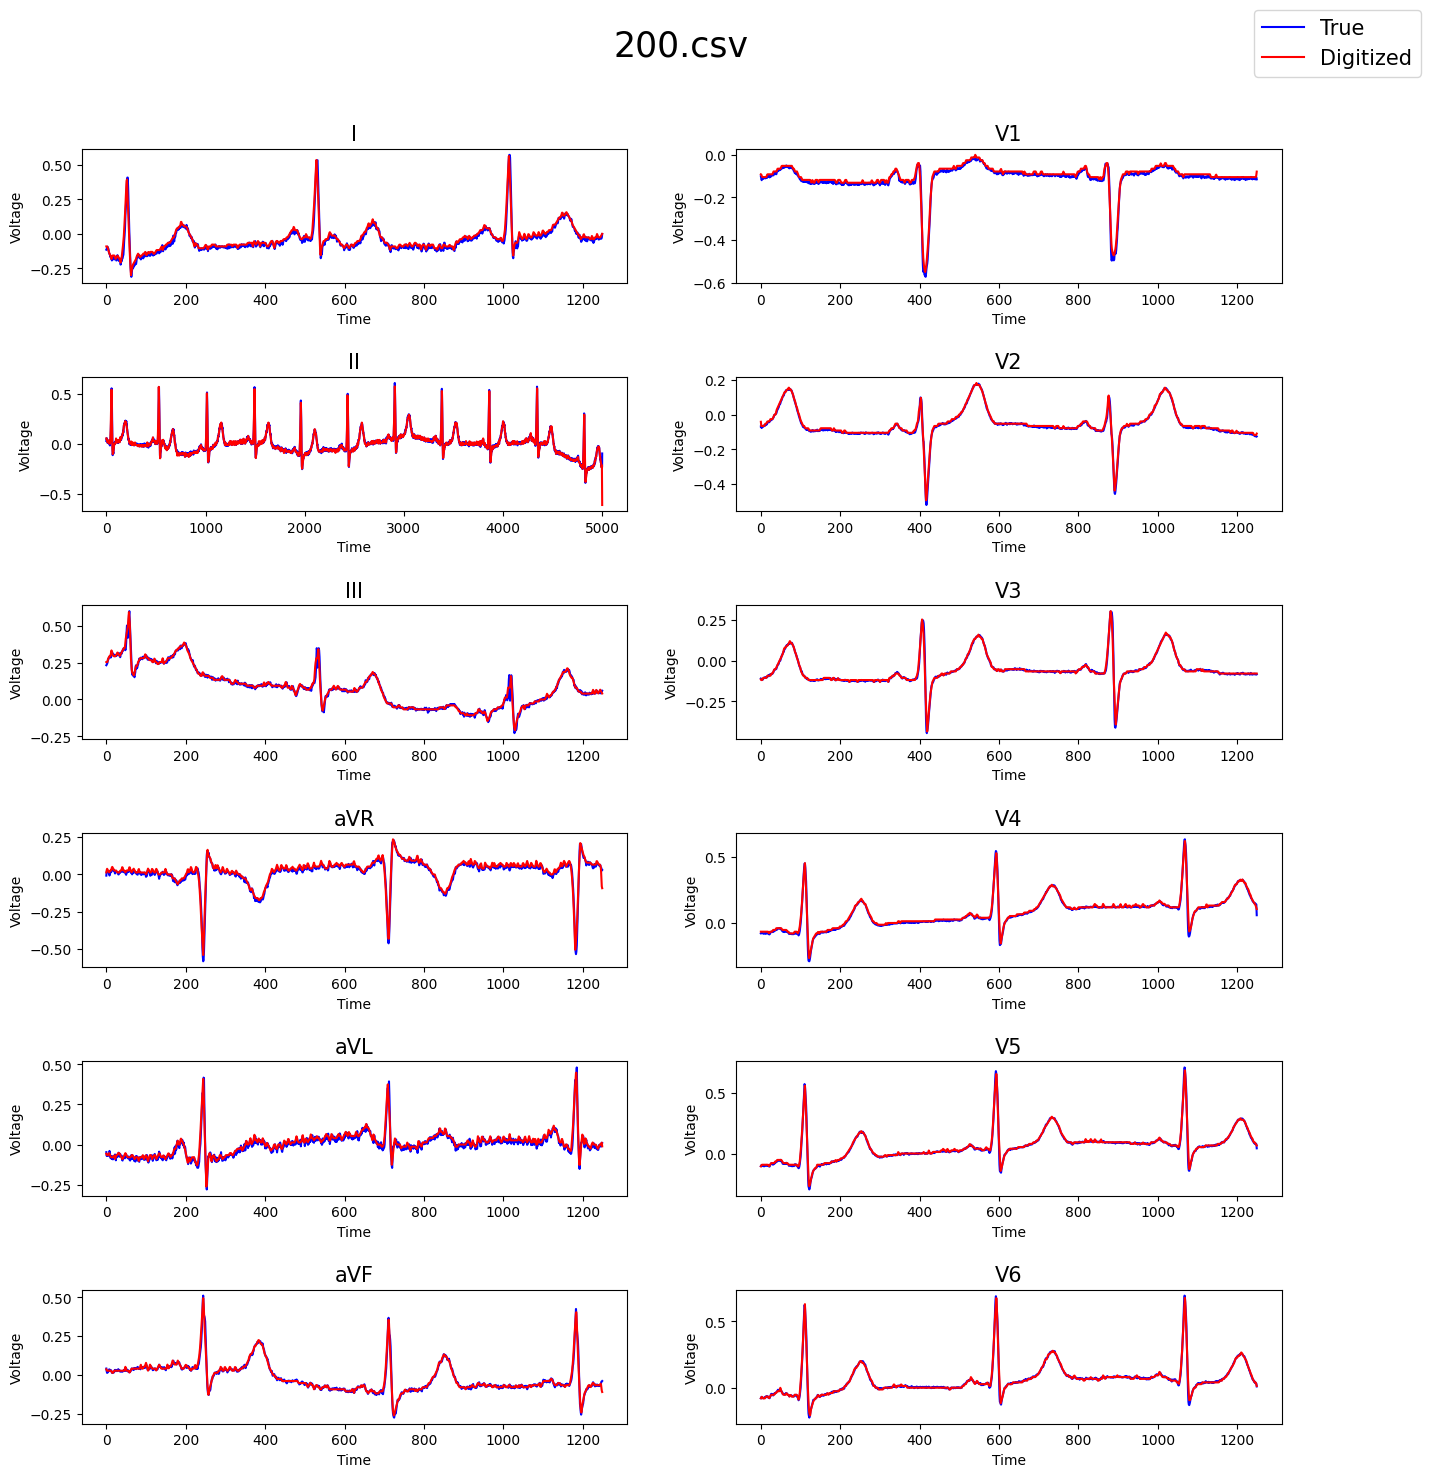

In [30]:
visualize("001.csv")
visualize("050.csv")
visualize("100.csv")
visualize("150.csv")
visualize("200.csv")